# Project Notebook




The task is to produce a neural process which is tailored to solve a physical system.  In this case, the physical system to be solved is the heat diffusion across a two-dimensional grid.  There are three main changes I wish to make to the standard neural process.  These are listed below, along with a brief description of their physical motivation.

#### 1. Convolutional Encoder and Decoder block 
Spatial equivariance is built into the system, since the heat diffusion function does not have a spatially dependent forcing term.  All terms are based on derivatives, which means the solution obeys spatial equivariance.  I hope to replicate this feature in the architecture, allowing for an easier learning process.
#### 2. Learning using Privileged Information
Learning using privileged information (LUPI) allows the model, while training, to have access to 'privileged information' (PI).  PI could be anything important the model should be aware of.  For example, if the total energy in the grid is conserved, imput this as PI.  When it comes to test time, the model does not have access to any PI.  The hope is that the model can infer what the PI should be (e.g. by figuring out what the total energy is and conserving it), making for a faster learning process.  There is a wide variety of PI to be used and experimented with.  A few more examples are: initial conditions, final conditions, decay constant, entropy measure.

The way the PI is implemented is through an encoder which runs separately to the usual encoder.  The PI embedding is then aggregated with the embedding of the data using a residual neural network; we do not want the PI to dominate the learning, but merely to add a `first order correction' to the learning process.  The good thing about this structure is that the PI can be added to any encoder block (e.g. flat encoder or convolutional encoder)

#### 3. Future...Time-Order Respecting Aggregator
In a neural process, the embeddings of the data at different times, $t_i$, are aggregated with a permutation invariant aggregator.  This is not usually useful for physical processes, as there tends to be a time-respecting process such as increase in entropy (in this case, diffusion of heat).  Therefore, it might be useful to reflect this in the aggregator.  The aggregator is such that there is no information leak from future to past - it imposes causality.

The aggregator could also be designed to reflect temporal equivariance, for the same reasons as the spatial equivariance: the diffusion equation involves no terms which depend explicitly on time, but rather only the derivative with resepct to time.  If the model is temporally equivariant, it may perform much better on extrapolation tasks (as it is not completely `blind' when it heads out of the sample, having learnt temporal behaviour)

One possible choice for this is to allow the model to `learn' these features by implementing a multi-head attention network.  However, with this option there is far less control over which physical concepts I am imposing.


I hope these three changes will improve on the most basic vanilla neural process architecture to learn the heat diffusion behaviour over a two-dimensional grid, as they are all grounded in physical concepts. 

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from scipy.integrate import odeint


# grab the neural process functions from Emilien Dupont's library called neural-processes
import sys

sys.path.insert(0, "./neural-processes")

# neural_process.py and training.py exist in neural-processes folder
import neural_process
from neural_process import NeuralProcessConv, NeuralProcess
from training import NeuralProcessTrainer
from utils import context_target_split
from heat_diffusion_dataset import Initial_Conditions, Diffusion_Data, RestoredData
from visualise import *

import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 18,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)



/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/usr/local/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/usr/local/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


# Diffusion Data

Heat Diffusion data was chosen as a suitable dataset to test my model.  The equation which the data follows is 

\begin{equation}
\frac{\partial u(x, y, t)}{\partial t} = D \nabla^2 u(x, y, t)
\end{equation} 

The boundary conditions are chosen to be Neumann Boundary Conditions, specifying the normal gradient to be zero at the boundaries

\begin{equation}
\left. \frac{\partial u}{\partial x} \right|_{x = 0, L} = \left. \frac{\partial u}{\partial y}\right|_{y=0, L} = 0
\end{equation}

These boundary conditions ensure heat remains inside the grid and cannot escape (the flux through the boundary is zero).  There are no sources or sinks, so the total heat energy in the grid is conserved.

The variation between datasets lies in the initial conditions.  There are three parameters for the initial conditions which are changed. 
1. Initial temperature 
2. Location of initial temperature spike
3. Broadness of initial temperature spike 

The overall heat energy in the grid therefore can change from dataset to dataset, but remains constant within each one.  The diffusion coefficient is also the same for each dataset.  This could replicate, for example, heat diffusion in a fixed medium with varying initial conditions.

Finite difference method (FDM) is used to solve equation 1.  The Laplacian is calculated using the five-point stencil finite difference method *Appendix.  This posed a difficulty when the initial conditions contained a discontinuous jump in temperature because Laplacian would become very large near the jump points.  To solve this issue, instead of implementing a different more advanced solver such as finite element methods (which may take a longer time to compute), a Gaussian filter was applied to smooth the initial conditions *Appendix.  The Gaussian filter was imported from `scipy.ndimage` module.

FDM becomes unstable when $\Delta t \leq \frac{\Delta x^2}{4D}$ *appendix, reference

In [2]:
dimensions = {
    't_dim' : 1,
    'y_dim' : 50**2,
    'r_dim' : 128,
    'h_dim' : 128,
    'z_dim' : 128,
    'max_iter_time' : 500,
    'grid_size' : 50,
    'num_samples' : 40,
    'num_context' : 30,
    'num_target' : 30,
    'batch_size' : 2,
    'num_channels' : 16,
    'pi_dim' : 4
}

assert dimensions['grid_size']**2 == dimensions['y_dim']
assert dimensions['num_context'] + dimensions['num_target'] <= dimensions['max_iter_time']

# parameters
grid_size = dimensions['grid_size']
num_samples = dimensions['num_samples']
square_range = (5, 15) # side length of initial hot square
temp_range = (1.0, 2.0)
diffusion_coef = 0.25 * dimensions['max_iter_time'] # upper limit for stable FDM solver

assert diffusion_coef <= 0.25 * dimensions['max_iter_time']

In [3]:
''' 
RUN TO RE-GENERATE DATA
'''
# Abstraction classes to make data in readable format
class MetaData():
    def __init__(self, meta_data, ds_num):
        # Only access first data set in the meta-dataset 
        self.t = meta_data[ds_num][0]
        self.y = meta_data[ds_num][1]
        self.pi = meta_data[ds_num][2]

class Pi():
    def __init__(self, pi):
        self.diffusion_coef = pi[:, 0]
        self.max_temp = pi[:, 1]
        self.energy = pi[:, 2]
        self.entropy = pi[:, 3]


initial_conditions = Initial_Conditions(
    max_iter_time=dimensions['max_iter_time'], grid_size=grid_size
)

meta_data = Diffusion_Data(
    num_samples=num_samples,
    max_iter_time=dimensions['max_iter_time'],
    grid_size=grid_size,
    initial_conditions=initial_conditions,
    square_range=square_range,
    temp_range=temp_range,
    diffusion_coef=diffusion_coef,
    sigma=3
)

time_array = meta_data.time_array

# meta_data.save_tensors()

/Users/alexking/Documents/part_III_project/./neural-processes/heat_diffusion_dataset.py:184: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  entropy[np.isnan(entropy)] = 0


In [4]:
print(len(meta_data.data))
print(len(meta_data[0]))
print(meta_data[0][0].shape)
print(meta_data[0][1].shape)
print(meta_data[0][2].shape)

meta_data[4][2] == meta_data[3][2]

40
3
torch.Size([500, 1])
torch.Size([500, 2500])
torch.Size([500, 4])


tensor([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        ...,
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

#### Visualize Target Data

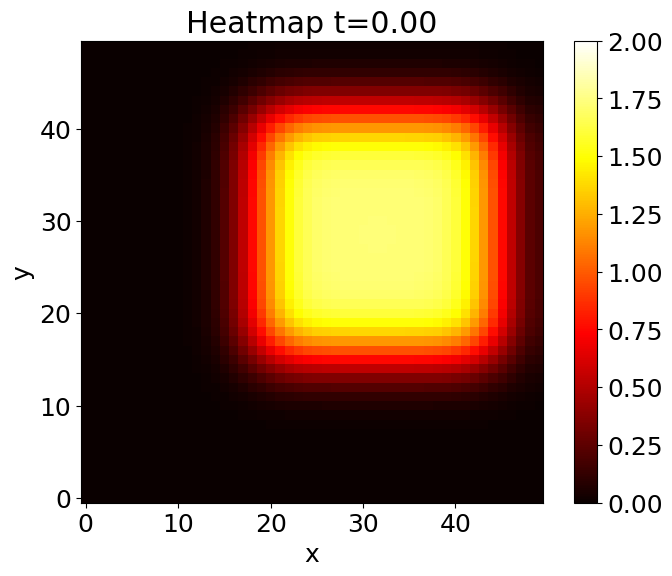

In [5]:
'''
Plot heatmap
'''

u = meta_data.data[5][1][0, :].reshape(dimensions['grid_size'], dimensions['grid_size'])
plt.imshow(u, cmap="hot", origin="lower", vmin=0.0, vmax=2.0)
plt.colorbar()
plt.title("Heatmap t={:.2f}".format(time_array[0]))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Privileged Information Data

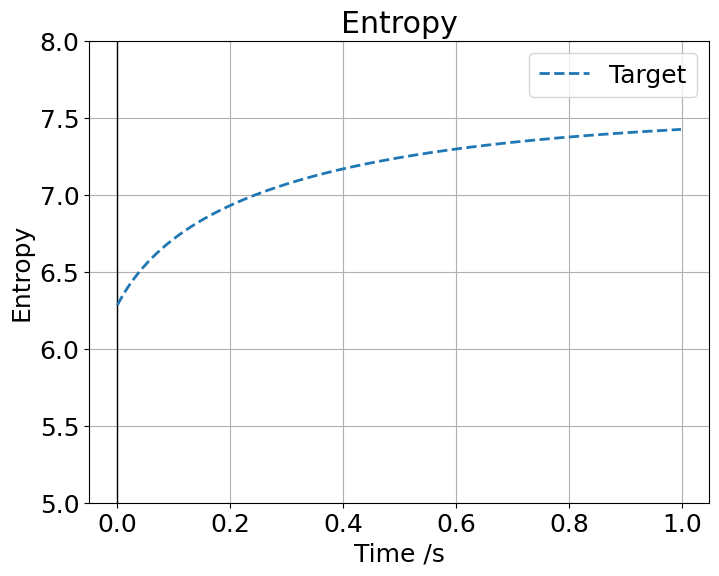

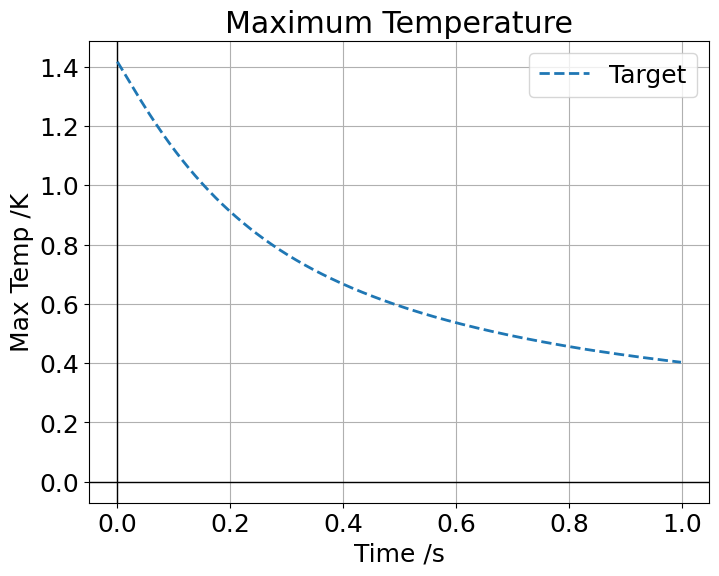

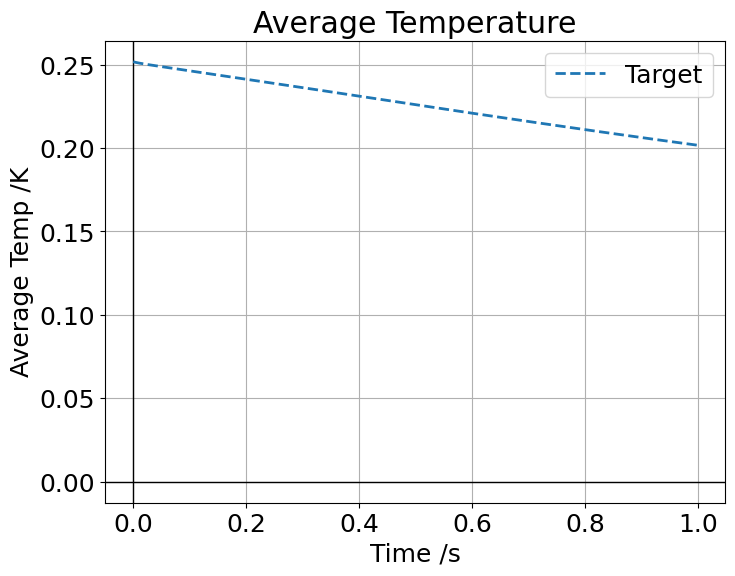

tensor(0.8014)


In [6]:
''' 
Plot privileged information
'''
out_entropy = torch.full((dimensions['max_iter_time'],), 0)
out_max_temp = torch.full((dimensions['max_iter_time'],), 0)
out_energy = torch.full((dimensions['max_iter_time'],), 0)

for ds_num in range(dimensions['num_samples']-1):
    ds = MetaData(meta_data.data, ds_num=ds_num)
    pi = Pi(ds.pi)
    out_entropy = out_entropy + pi.entropy
    out_max_temp = out_max_temp + pi.max_temp
    out_energy = out_energy + pi.energy
out_entropy = out_entropy / dimensions['num_samples']
out_max_temp = out_max_temp / dimensions['num_samples']
out_energy = out_energy / dimensions['num_samples']

plot_pi_data(out_entropy, np_mean=None, lupi_mean=None, conv_mean=None, title='Entropy', xlabel='Time /s', ylabel='Entropy')
plot_pi_data(out_max_temp, np_mean=None, lupi_mean=None, conv_mean=None, title='Maximum Temperature', xlabel='Time /s', ylabel='Max Temp /K')
plot_pi_data(out_energy, np_mean=None, lupi_mean=None, conv_mean=None, title='Average Temperature', xlabel='Time /s', ylabel='Average Temp /K')
print(out_energy[-1] / out_energy[0])


In [7]:
from models import Net, Encoder, Decoder, TransposedConvNet, LupiEncoder, RepresentationAggregator, MuSigmaEncoder

net = Net(dimensions)
encoder = Encoder(dimensions)
decoder = Decoder(dimensions)
transposedconvnet = TransposedConvNet(dimensions)
lupi_encoder = LupiEncoder(dimensions)
representation_aggregator = RepresentationAggregator(dimensions)
mu_sigma_encoder = MuSigmaEncoder(dimensions)

all_models = {
    'net' : net,
    'encoder': encoder,
    'decoder': decoder,
    'transposedconvnet':transposedconvnet,
    'lupi_encoder':lupi_encoder,
    'representation_aggregator':representation_aggregator,
    'mu_sigma_encoder':mu_sigma_encoder
}


def count_model_params(model):
    return sum(p.numel() for p in model.parameters(model) if p.requires_grad)

for k, v in all_models.items():
    print('model {} has {} parameters'.format(k, count_model_params(v)))

np_params = (
    count_model_params(all_models['encoder']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['decoder'])
)

lupi_params = (
    count_model_params(all_models['encoder']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['lupi_encoder']) 
    + count_model_params(all_models['representation_aggregator']) 
    + count_model_params(all_models['decoder'])
)

conv_params = (
    count_model_params(all_models['net']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['decoder']) 
)


print('NP has {} learnable parameters'.format(np_params))
print('LUPI has {} learnable parameters'.format(lupi_params))
print('Conv has {} learnable parameters'.format(conv_params))

model net has 18294 parameters
model encoder has 353280 parameters
model decoder has 694664 parameters
model transposedconvnet has 19462 parameters
model lupi_encoder has 33792 parameters
model representation_aggregator has 65920 parameters
model mu_sigma_encoder has 49536 parameters
NP has 1097480 learnable parameters
LUPI has 1197192 learnable parameters
Conv has 762494 learnable parameters


## CPU runtime

In [26]:
from torch.autograd import profiler
profiler.profile(enabled=True)
reps = 10

overall_time = np.full((reps,), -1)

for i in range(reps):
    with profiler.profile() as prof:

        np_test = NeuralProcessConv(dimensions)

        dl = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
        op = torch.optim.Adam(np_test.parameters(), lr=1e-4)
        trainer_test = NeuralProcessTrainer(
            "cuda",
            np_test,
            op,
            num_context_range=(dimensions['num_context'], dimensions['num_context']),
            num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
            print_freq=1000,
            grid_size=dimensions['grid_size']
        )

        np_test.training = True
        trainer_test.train(dl, 1)
            
    result = prof.self_cpu_time_total
    # Extract overall time taken
    overall_time[i] = result
    # profiler.profile(enabled=False)
    # print(prof.key_averages().table(sort_by="self_cpu_time_total"))
print('NP average time taken is {} ± {} ms'.format(overall_time.mean() / 1000, overall_time.std() / 1000))

# torch.save(neuralprocess.state_dict(), './trainers/neuralprocess_dict')
# torch.save(np_trainer.epoch_loss_history, './metadata/epoch_loss_history')


STAGE:2023-05-10 15:46:46 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98758.87109375


STAGE:2023-05-10 15:46:48 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:46:56 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98645.1109375


STAGE:2023-05-10 15:46:58 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:05 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98676.72265625


STAGE:2023-05-10 15:47:06 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:13 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98638.362890625


STAGE:2023-05-10 15:47:15 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:23 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98809.796875


STAGE:2023-05-10 15:47:24 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:31 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98355.65234375


STAGE:2023-05-10 15:47:33 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:40 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98885.8984375


STAGE:2023-05-10 15:47:41 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:50 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98808.39921875


STAGE:2023-05-10 15:47:52 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:59 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98901.808203125


STAGE:2023-05-10 15:48:01 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:48:08 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98850.46640625


STAGE:2023-05-10 15:48:10 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection


NP average time taken is 1241.358 ± 106.78075874238768 ms


## Neural Process

In [9]:
neuralprocess = NeuralProcess(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=1e-4)
np_trainer = NeuralProcessTrainer(
    "cuda",
    neuralprocess,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=1000,
    is_lupi=False
)

neuralprocess.training = True
np_trainer.train(data_loader, 2000)

torch.save(neuralprocess.state_dict(), './trainers/neuralprocess_dict')
torch.save(np_trainer.epoch_loss_history, './metadata/epoch_loss_history')

Epoch: 0, Avg_loss: 103244.8671875
Epoch: 1, Avg_loss: 101567.943359375
Epoch: 2, Avg_loss: 97922.165234375
Epoch: 3, Avg_loss: 83376.18828125
Epoch: 4, Avg_loss: 66127.3212890625
Epoch: 5, Avg_loss: 47210.50595703125
Epoch: 6, Avg_loss: 34585.54787597656
Epoch: 7, Avg_loss: 35061.68251953125
Epoch: 8, Avg_loss: 22621.114782714845
Epoch: 9, Avg_loss: 17396.444146728514
Epoch: 10, Avg_loss: 21519.64210205078
Epoch: 11, Avg_loss: 16835.44411315918
Epoch: 12, Avg_loss: 11633.16057434082
Epoch: 13, Avg_loss: 6628.415469360351
Epoch: 14, Avg_loss: 8738.446472167969
Epoch: 15, Avg_loss: 1044.818733215332
Epoch: 16, Avg_loss: 1352.0465881347657
Epoch: 17, Avg_loss: 2727.0573760986326
Epoch: 18, Avg_loss: 4015.1898681640623
Epoch: 19, Avg_loss: -1739.698194885254
Epoch: 20, Avg_loss: 293.270449590683
Epoch: 21, Avg_loss: -4929.396936035157
Epoch: 22, Avg_loss: -3498.754742431641
Epoch: 23, Avg_loss: -7429.481826782227
Epoch: 24, Avg_loss: -7684.422860717774
Epoch: 25, Avg_loss: -7007.817653274

## CONVOLUTIONAL ENCODER 

In [8]:
conv_neuralprocess = NeuralProcessConv(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(conv_neuralprocess.parameters(), lr=1e-4)
conv_np_trainer = NeuralProcessTrainer(
    "cuda",
    conv_neuralprocess,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=1000,
    grid_size=dimensions['grid_size'],
)

conv_neuralprocess.training = True
conv_np_trainer.train(data_loader, 2000)

# print(prof.key_averages().table(sort_by="self_cpu_time_total"))

torch.save(conv_neuralprocess.state_dict(), './trainers/conv_neuralprocess_dict')
torch.save(conv_np_trainer.epoch_loss_history, './metadata/conv_epoch_loss_history')


Epoch: 0, Avg_loss: 103012.61953125
Epoch: 1, Avg_loss: 101470.406640625
Epoch: 2, Avg_loss: 96696.47421875
Epoch: 3, Avg_loss: 83210.2109375
Epoch: 4, Avg_loss: 63540.5087890625
Epoch: 5, Avg_loss: 43711.20400390625
Epoch: 6, Avg_loss: 28207.87603149414
Epoch: 7, Avg_loss: 9261.011499023438
Epoch: 8, Avg_loss: 1996.8446899414062
Epoch: 9, Avg_loss: -2503.2095947265625
Epoch: 10, Avg_loss: -1177.4193359375
Epoch: 11, Avg_loss: -4686.955102539063
Epoch: 12, Avg_loss: -5633.098400878906
Epoch: 13, Avg_loss: -4889.891955566406
Epoch: 14, Avg_loss: -5403.21552734375
Epoch: 15, Avg_loss: -5166.159216308593
Epoch: 16, Avg_loss: -7858.203051757812
Epoch: 17, Avg_loss: -1721.2957397460937
Epoch: 18, Avg_loss: -4134.3216552734375
Epoch: 19, Avg_loss: -9776.921422576905
Epoch: 20, Avg_loss: -11088.634854125976
Epoch: 21, Avg_loss: -9228.02852935791
Epoch: 22, Avg_loss: -8112.675717163086
Epoch: 23, Avg_loss: -11145.378833007813
Epoch: 24, Avg_loss: -9299.354541015626
Epoch: 25, Avg_loss: -10261.

## LUPI

In [11]:
neuralprocess_pi = NeuralProcess(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(neuralprocess_pi.parameters(), lr=1e-4)
np_trainer_pi = NeuralProcessTrainer(
    "cuda",
    neuralprocess_pi,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=1000,
    is_lupi=True
)

neuralprocess_pi.training = True
np_trainer_pi.train(data_loader, 2000)

torch.save(neuralprocess_pi.state_dict(), './trainers/neuralprocess_pi_dict')
torch.save(np_trainer_pi.epoch_loss_history, './metadata/lupi_epoch_loss_history')

Epoch: 0, Avg_loss: 102951.331640625
Epoch: 1, Avg_loss: 99867.35390625
Epoch: 2, Avg_loss: 86735.224609375
Epoch: 3, Avg_loss: 64136.9294921875
Epoch: 4, Avg_loss: 37624.25458984375
Epoch: 5, Avg_loss: 22806.789630126954
Epoch: 6, Avg_loss: 6380.513214111328
Epoch: 7, Avg_loss: 780.4511322021484
Epoch: 8, Avg_loss: -1190.0656646728517
Epoch: 9, Avg_loss: -1519.2395263671874
Epoch: 10, Avg_loss: -3444.376843261719
Epoch: 11, Avg_loss: -4805.807897949218
Epoch: 12, Avg_loss: -7137.6871337890625
Epoch: 13, Avg_loss: -5947.110180664063
Epoch: 14, Avg_loss: -8351.481884765624
Epoch: 15, Avg_loss: -9349.166442871094
Epoch: 16, Avg_loss: -9998.984533691406
Epoch: 17, Avg_loss: -11108.275134277344
Epoch: 18, Avg_loss: -11273.459982299804
Epoch: 19, Avg_loss: -10773.510269165039
Epoch: 20, Avg_loss: -10531.084228515625
Epoch: 21, Avg_loss: -9604.30526123047
Epoch: 22, Avg_loss: -12503.223913574218
Epoch: 23, Avg_loss: -9909.31865234375
Epoch: 24, Avg_loss: -15071.598684692382
Epoch: 25, Avg_lo

# TESTING

#### Reload Models

In [114]:
# class Result():
#     def __init__(self, result):
#         self.pi
#         self.t
#         self.y_mean
#         self.y_var



In [17]:
neuralprocess = NeuralProcess(dimensions)
neuralprocess.load_state_dict(torch.load('./trainers/neuralprocess_dict'))

conv_neuralprocess = NeuralProcess(dimensions)
conv_neuralprocess.load_state_dict(torch.load('./trainers/conv_neuralprocess_dict'))

neuralprocess_pi = NeuralProcess(dimensions)
neuralprocess_pi.load_state_dict(torch.load('./trainers/neuralprocess_pi_dict'))

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)

#### Obtain Results from Test Data

In [12]:
def test_model(neuralprocess, t_context, y_context, t_target, y_target, dimensions=dimensions, noise=False):
    # Switch to test mode
    neuralprocess.training = False

    # Extract models' distributions over t_target and grid
    p_y_pred = neuralprocess(t_context, y_context, t_target)

    # flat NP
    y_mean = p_y_pred.loc.detach().numpy()[0]
    y_var = p_y_pred.scale.detach().numpy()[0]

    # flat NP reshape
    y_mean = y_mean.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))
    y_var = y_var.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

    return y_target, torch.Tensor(y_mean), torch.Tensor(y_var)



In [13]:
# How many iterations to average the noise over 
noise_iters = 20

# Select which models to test
test_convolutional_neural_process = True
test_lupi_neural_process = True
test_flat_neural_process = True

batches = [batch for batch in data_loader]

# Use batch to create random set of context points
t, y, pi = batches[np.random.randint(0, len(batches))]
t_context, y_context, _, _, _, _ = context_target_split(
    t[0:1], y[0:1], pi[0:1], dimensions['num_context'], dimensions['num_target']
)

# Create a set of target points corresponding to in-sample time range
t_target = torch.linspace(0, 1, dimensions['max_iter_time'])
t_target = t_target.unsqueeze(1).unsqueeze(0)

# Extract mean of distribution
# t_out = t_target.numpy()[0]

# target output
y_target = y[0:1][0, :, :]
y_target = y_target.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

if test_lupi_neural_process:
    y_target, lupi_y_mean, lupi_y_var = test_model(neuralprocess_pi, t_context, y_context, t_target, y_target)
    lupi_loss = torch.load('./metadata/lupi_epoch_loss_history')
    lupi_y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        lupi_y_noise = lupi_y_noise + test_model(neuralprocess_pi, t_context, white_noise, t_target, y_target, noise=True)[1]
    
    lupi_y_noise = lupi_y_noise / noise_iters
    
if test_flat_neural_process:
    y_target, y_mean, y_var = test_model(neuralprocess, t_context, y_context, t_target, y_target)
    loss = torch.load('./metadata/epoch_loss_history')
    y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        y_noise = y_noise + test_model(neuralprocess, t_context, white_noise, t_target, y_target, noise=True)[1]
    y_noise = y_noise / noise_iters

if test_convolutional_neural_process:
    y_target, conv_y_mean, conv_y_var = test_model(conv_neuralprocess, t_context, y_context, t_target, y_target)
    conv_loss = torch.load('./metadata/conv_epoch_loss_history')
    conv_y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        conv_y_noise = conv_y_noise + test_model(conv_neuralprocess, t_context, white_noise, t_target, y_target, noise=True)[1]
    conv_y_noise = conv_y_noise / noise_iters


#### Make sure data is in correct format

In [14]:
assert y_target.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])

# Main Results

#### Metric 1: Mean Accuracy

- MSE
- Log Likelihood
- Time to compute

In [15]:
reps = 100
np_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
lupi_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
conv_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
np_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
lupi_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
conv_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)

for i in range(reps):
    # Extract a batch from data_loader
    batches = [batch for batch in data_loader]

    # Use batch to create random set of context points
    t, y, pi = batches[np.random.randint(0, len(batches))]
    t_context, y_context, _, _, _, _ = context_target_split(
        t[0:1], y[0:1], pi[0:1], dimensions['num_context'], dimensions['num_target']
    )

    # Create a set of target points corresponding to in-sample time range
    t_target = torch.linspace(0, 1, dimensions['max_iter_time'])
    t_target = t_target.unsqueeze(1).unsqueeze(0)

    # target output
    y_target = y[0:1][0, :, :]
    y_target = y_target.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

    y_target, y_mean, y_var = test_model(neuralprocess, t_context, y_context, t_target, y_target)
    y_target, lupi_y_mean, lupi_y_var = test_model(neuralprocess_pi, t_context, y_context, t_target, y_target)
    y_target, conv_y_mean, conv_y_var = test_model(conv_neuralprocess, t_context, y_context, t_target, y_target)
    
    np_performance = Performance(y_target, y_mean, y_var, dimensions)
    np_mse = np_mse + np_performance.residual() 
    np_log_likelihood = np_log_likelihood + np_performance.log_likelihood()
    
    lupi_performance = Performance(y_target, lupi_y_mean, lupi_y_var, dimensions)
    lupi_mse = lupi_mse + lupi_performance.residual() 
    lupi_log_likelihood = lupi_log_likelihood + lupi_performance.log_likelihood()

    conv_performance = Performance(y_target, conv_y_mean, conv_y_var, dimensions)
    conv_mse = conv_mse + conv_performance.residual()
    conv_log_likelihood = conv_log_likelihood + conv_performance.log_likelihood()

np_mse = np_mse / reps
lupi_mse = lupi_mse / reps
conv_mse = conv_mse / reps
np_log_likelihood = np_log_likelihood / reps
lupi_log_likelihood = lupi_log_likelihood / reps
conv_log_likelihood = conv_log_likelihood / reps

print(
    "FLAT NP: MSE accuracy was {:.8f}, with std {:.8f}".format(
        np_mse.mean(), np_mse.std()
    ))

print(
    "LUPI NP: MSE accuracy was {:.8f}, with std {:.8f}".format(
        lupi_mse.mean(), lupi_mse.std()
    ))


print(
    "CONVOLUTION: MSE accuracy was {:.8f}, with std {:.8f}".format(
        conv_mse.mean(), conv_mse.std()
    ))

print(
    "FLAT NP: log-likelihood was {:.8f}, with std {:.8f}".format(
        np_log_likelihood.mean(), np_log_likelihood.std()
    ))


print(
    "LUPI NP: log-likelihood was {:.8f}, with std {:.8f}".format(
        lupi_log_likelihood.mean(), lupi_log_likelihood.std()
    ))


print(
    "CONVOLUTION: log-likelihood was {:.8f}, with std {:.8f}".format(
        conv_log_likelihood.mean(), conv_log_likelihood.std()
    ))

FLAT NP: MSE accuracy was 0.00442088, with std 0.01233861
LUPI NP: MSE accuracy was 0.00897583, with std 0.01349608
CONVOLUTION: MSE accuracy was 0.00366935, with std 0.00923649
FLAT NP: log-likelihood was 3.74463916, with std 1.28780377
LUPI NP: log-likelihood was 1.59596002, with std 0.34223282
CONVOLUTION: log-likelihood was 3.19473743, with std 0.98248011


#### Metric 2: Plot Losses as Function of Epoch

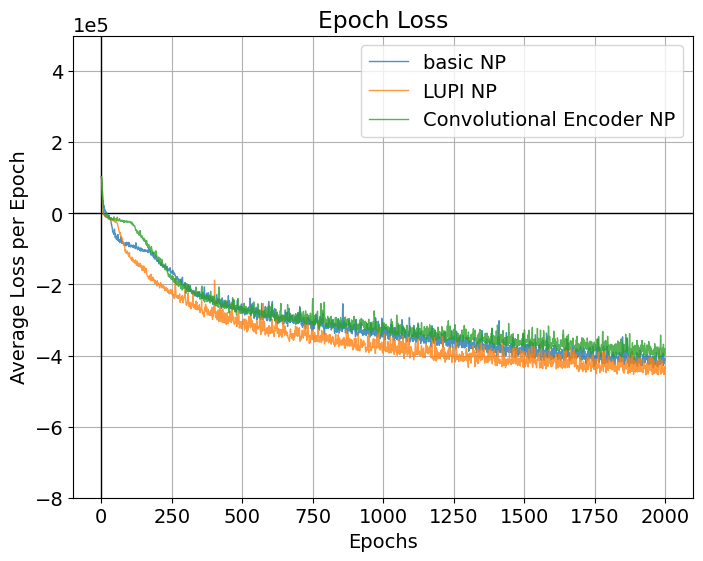

In [16]:
mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 14,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

plot_losses(loss=loss, lupi_loss=lupi_loss, conv_loss=conv_loss, plot_moving_average=False)


#### Metric 3: Heatmaps for Comparison



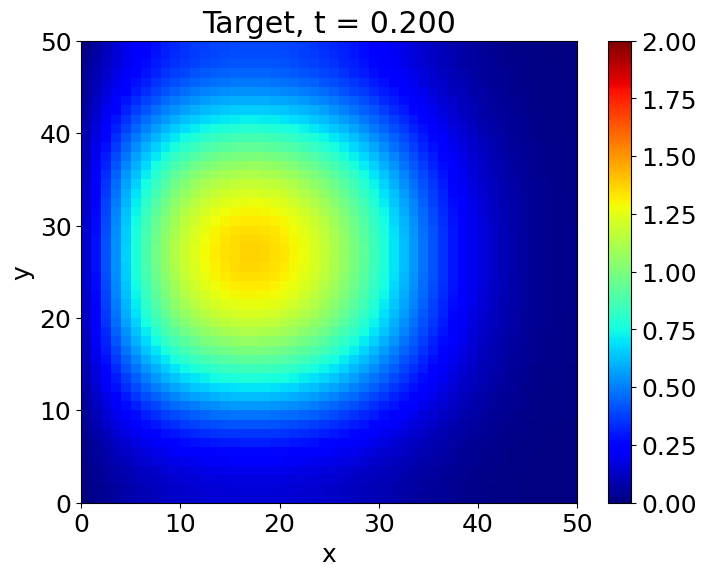

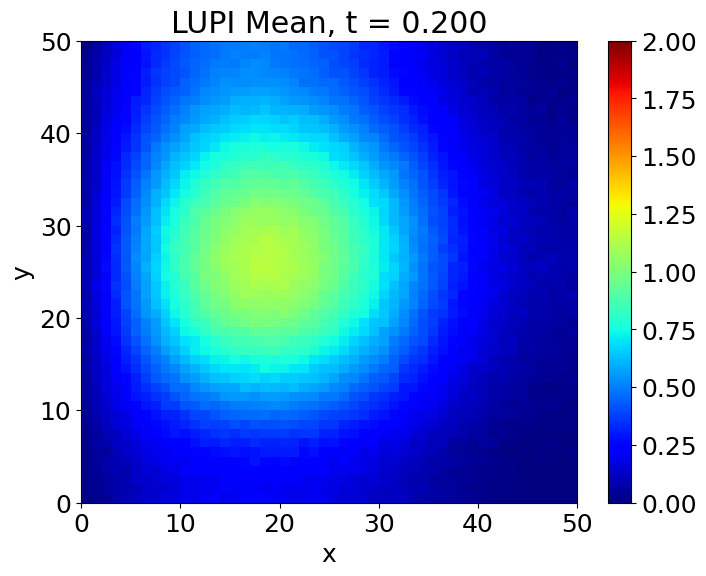

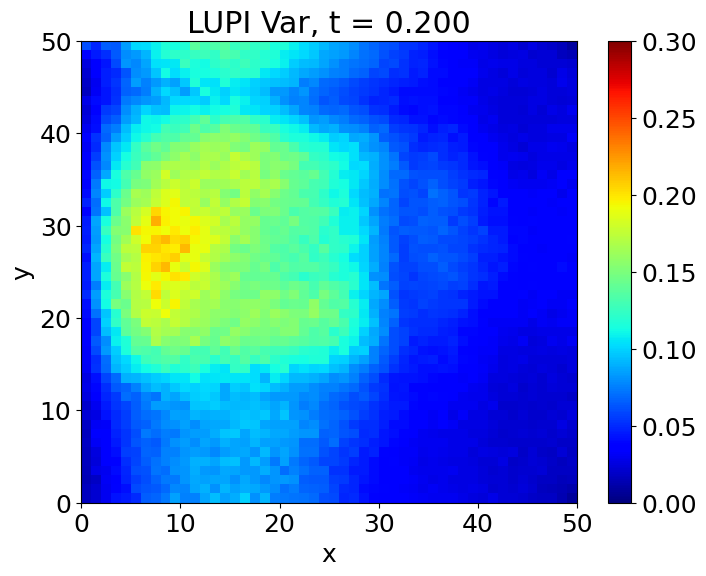

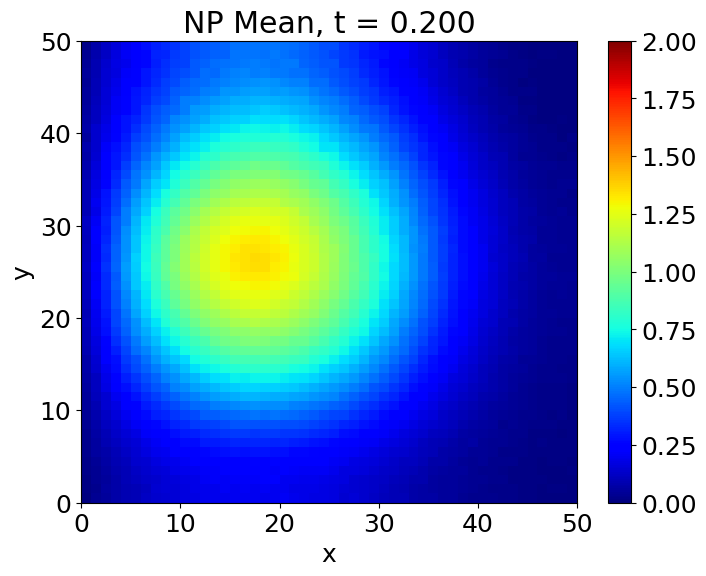

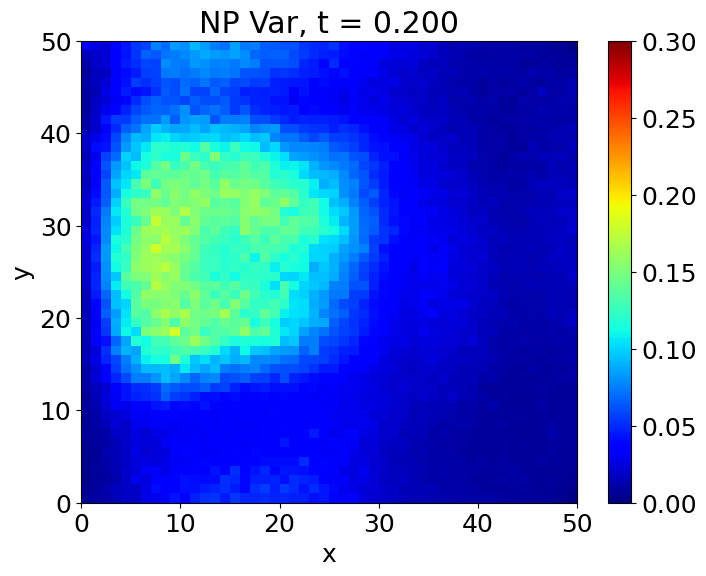

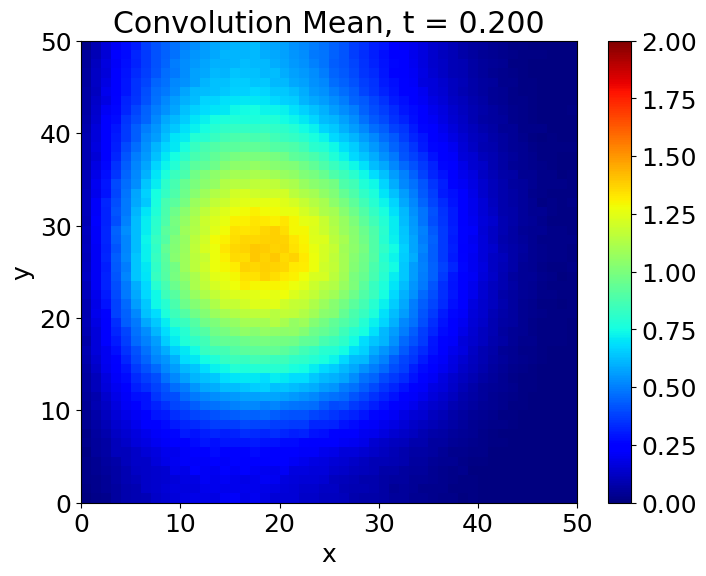

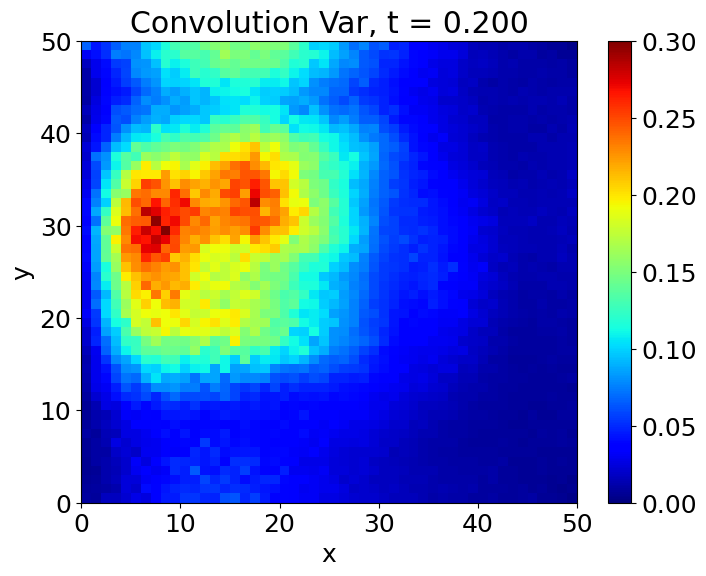

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [17]:
mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 18,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

visualise_model_solution(y_target, 100, title='Target', vmin=0.0, vmax=2.0)
visualise_model_solution(lupi_y_mean, 100, title='LUPI Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(lupi_y_var, 100, title='LUPI Var', vmin=0.0, vmax=0.3)
visualise_model_solution(y_mean, 100, title='NP Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(y_var, 100, title='NP Var', vmin=0.0, vmax=0.3)
visualise_model_solution(conv_y_mean, 100, title='Convolution Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(conv_y_var, 100, title='Convolution Var', vmin=0.0, vmax=0.3)


In [ ]:
''' 
PLOT OF INDIVIDUAL HEATMAPS AT SPECIFIC CHOSEN TIMES 
'''
def single_hm(result_k, k: int, max_iter_time: int, which_plot: str, title=None):
    if which_plot == "Target":
        i = 0
    elif which_plot == "Mean":
        i = 1
    elif which_plot == "Variance":
        i = 2
    else:
        print("Please put either Target, Mean or Variance for argument which_plot")
        raise KeyError

    # Clear the current plot figure
    plt.clf()
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    if title is None:
        plt.title(
            "Temperature at t = {:.3f} unit time, {}".format(
                k / max_iter_time, which_plot
            )
        )
    else:
        plt.title("{}, t = {:.3f}".format(title, k / max_iter_time))
    plt.pcolormesh(result_k[i], cmap=plt.cm.jet, vmin=0, vmax=2.0)
    plt.colorbar()
    plt.show()
    return plt

chosen_time_step = int(15)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Target', 
    title='Target Solution'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='NP Mean'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='NP Variance'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='LUPI Mean'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='LUPI Variance'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='Conv Mean'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='Conv Variance'
)


In [ ]:
''' 
PLOTS SIDE BY SIDE:

        TARGET          MEAN            VARIANCE

FOR VARIOUS TIMES SPECIFIED IN THE LISTS
'''


for k in [0, 10, 50, 99]:
    print("FLAT NP \n")
    plotheatmap(result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n LUPI NP \n")
    plotheatmap(lupi_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(lupi_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n CONV NP \n")
    plotheatmap(conv_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(conv_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)
    



#### Metric 4: Plot Residuals and compare to Variance

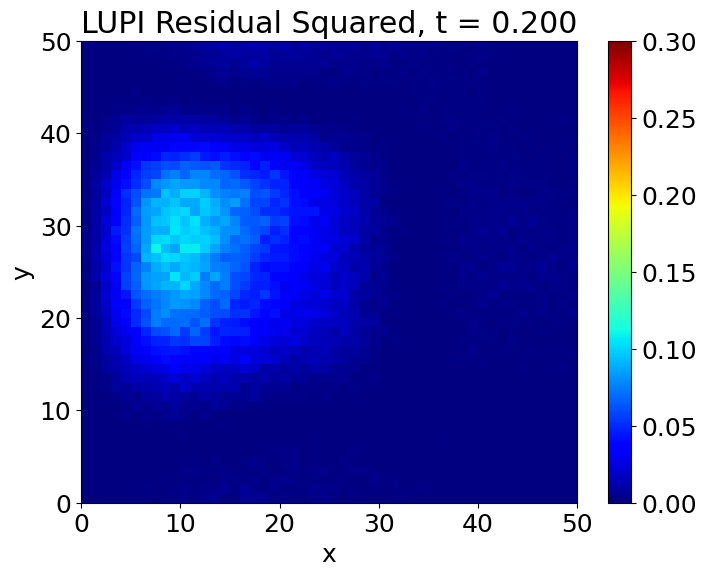

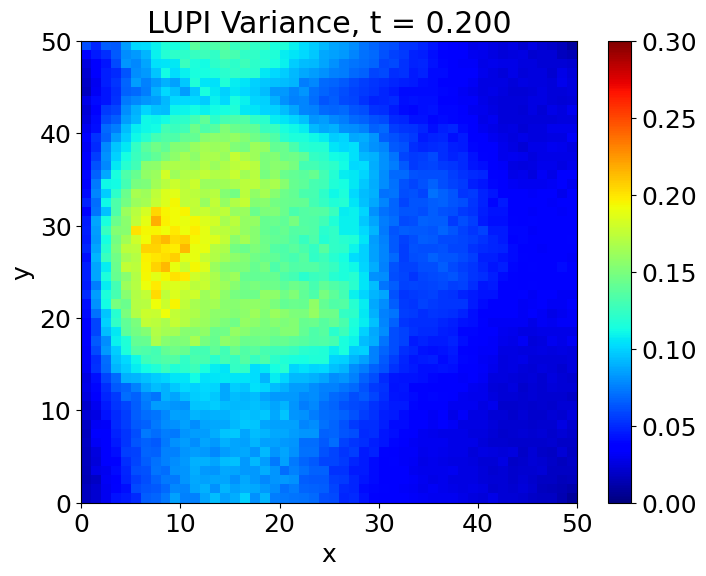

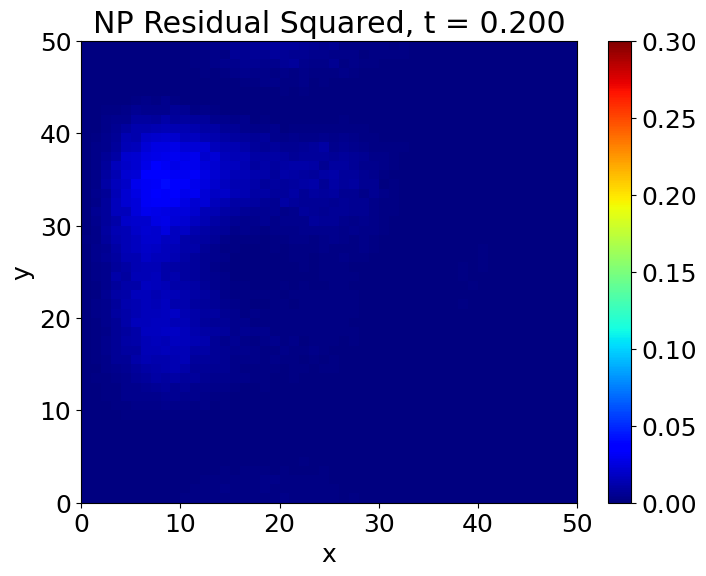

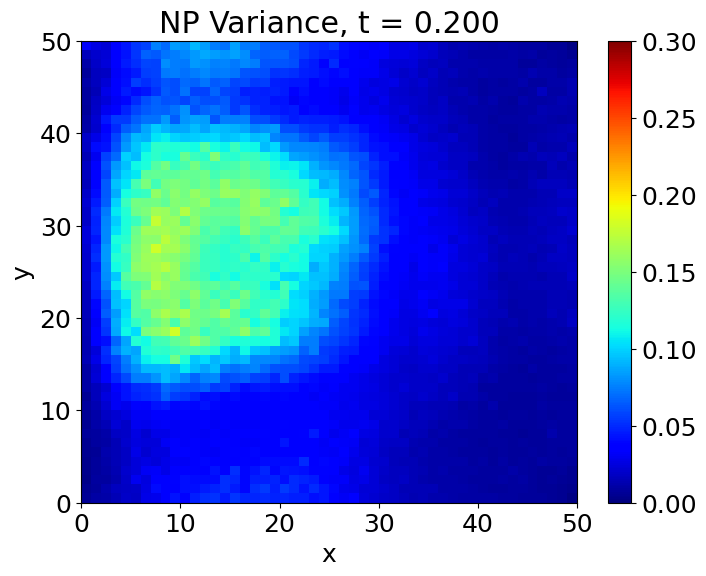

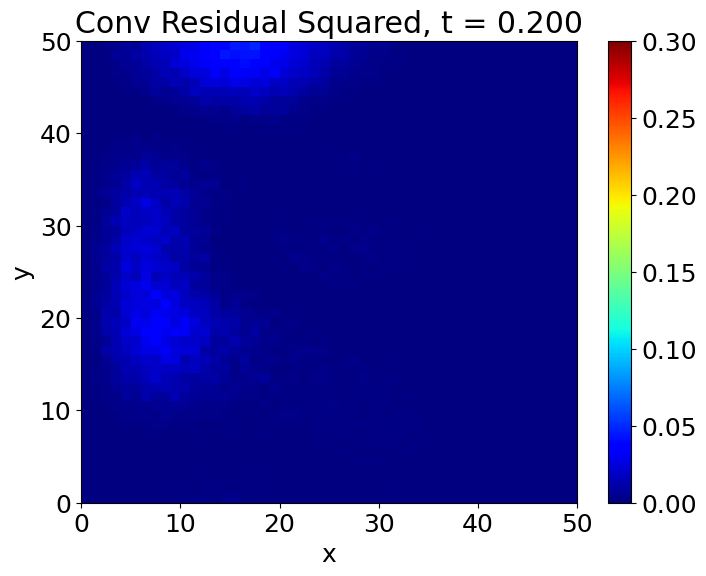

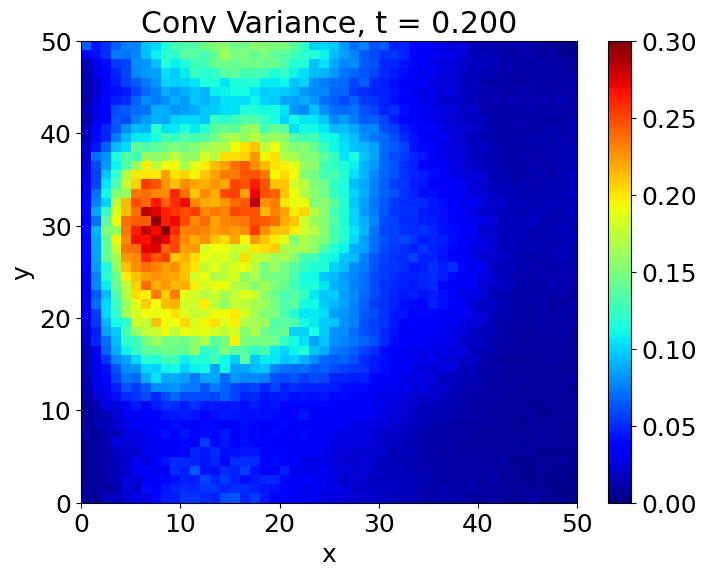

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [18]:
visualise_model_solution((lupi_y_mean - y_target)**2, 100, title='LUPI Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(lupi_y_var, 100, title='LUPI Variance', vmin=0.0, vmax=0.3)
visualise_model_solution((y_mean - y_target)**2, 100, title='NP Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(y_var, 100, title='NP Variance', vmin=0.0, vmax=0.3)
visualise_model_solution((conv_y_mean - y_target)**2, 100, title='Conv Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(conv_y_var, 100, title='Conv Variance', vmin=0.0, vmax=0.3)

In [ ]:
for i in [0, 5, 25, 75]:
    plot_residuals(conv_result, i, dimensions['max_iter_time'])

#### Noisey Input to Neural Process

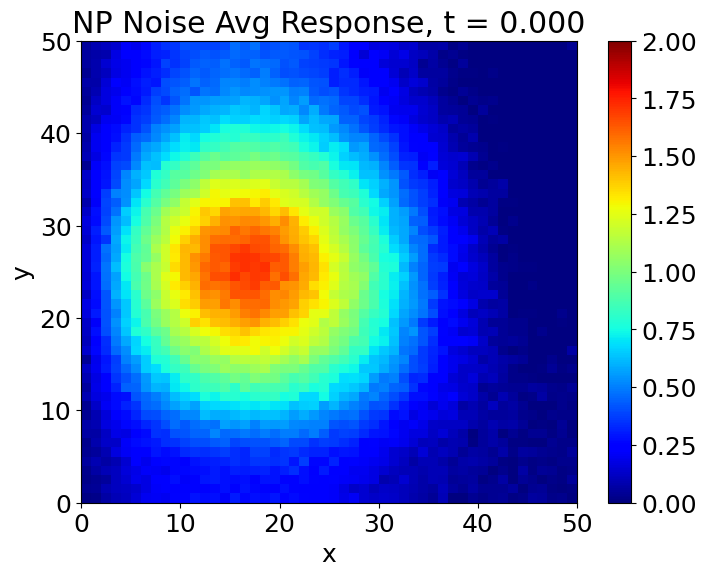

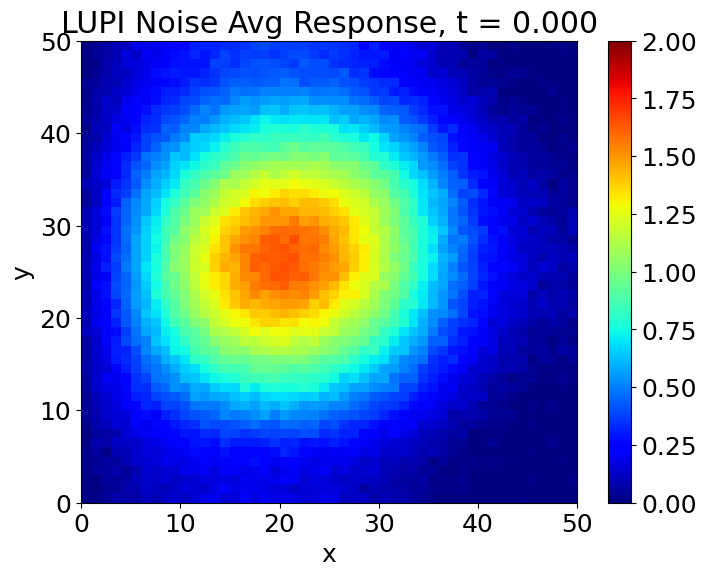

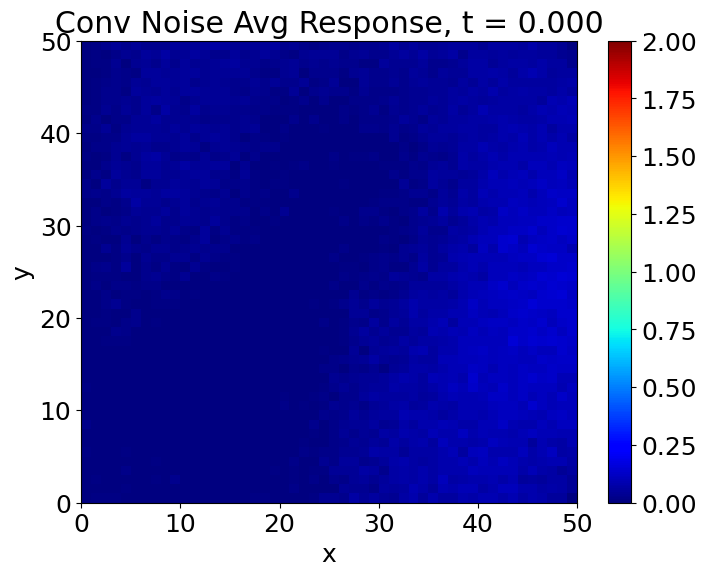

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [19]:
visualise_model_solution(y_noise, 0, title='NP Noise Avg Response')
visualise_model_solution(lupi_y_noise, 0, title='LUPI Noise Avg Response')
visualise_model_solution(conv_y_noise, 0, title='Conv Noise Avg Response')


## GIFS

## Heatmap of target and prediction mean

/var/folders/g2/t0t2b3mx2vbf989wdyrtxf1r0000gn/T/ipykernel_39549/2537561897.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  cax = plt.subplot(gs[-1])


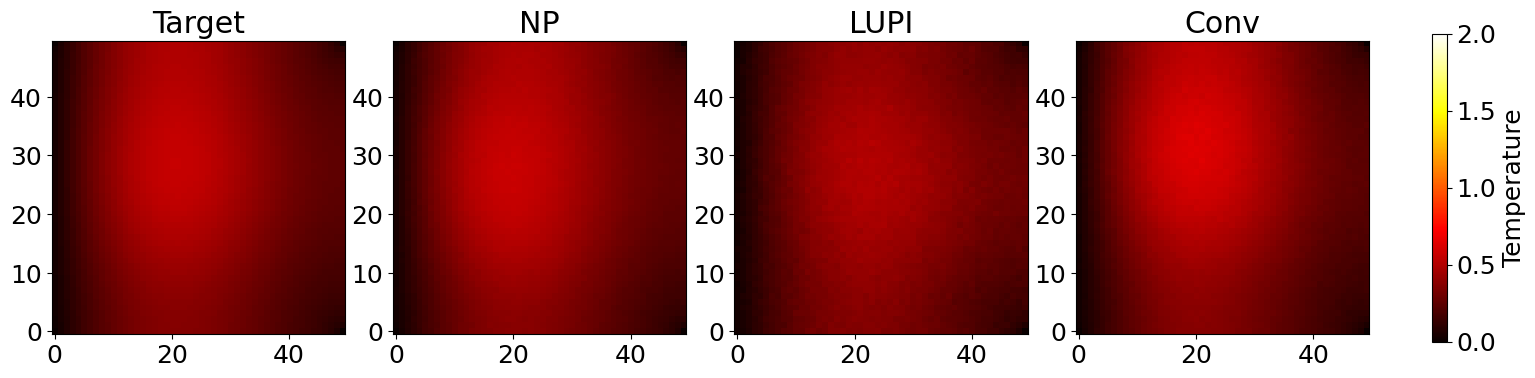

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

# Create a figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.10]})
gs = gridspec.GridSpec(1, 5, width_ratios=[1,1,1,1,0.05])

# Set up the subplots
titles = ['Target', 'NP', 'LUPI', 'Conv']
data = [y_target, y_mean, lupi_y_mean, conv_y_mean]
# data = [data1, data2, data3, data4]

images = []

# Plot initial heatmaps
for i, ax in enumerate(axes[:-1]):
    ax.set_title(titles[i])
    image = ax.imshow(data[i][0], cmap='hot', interpolation='nearest', animated=True, vmin=0.0, vmax=2.0)
    images.append(image)

    # Invert the y-axis
    ax.invert_yaxis()

    # Modify the y-axis ticks and tick labels
    # ax.set_yticks(np.arange(y_target.shape[1]))  # Set the tick positions
    # ax.set_yticklabels(np.linspace(0, y_target.shape[1], 3)[::-1])  # Set the tick labels in reverse order


# Create the colorbar
cax = plt.subplot(gs[-1])
cbar = plt.colorbar(images[0], cax=cax)
cbar.set_label('Temperature')

# Update heatmaps for each time step
def update_heatmaps(frame):
    for i, image in enumerate(images):
        image.set_array(data[i][frame])

# Create the animation
ani = animation.FuncAnimation(fig, update_heatmaps, frames=y_target.shape[0], interval=25)

# Save the animation as GIF
ani.save('target_mean.gif', writer='pillow')

# Show the plot
plt.show()


## Heatmap of residuals and prediction variance

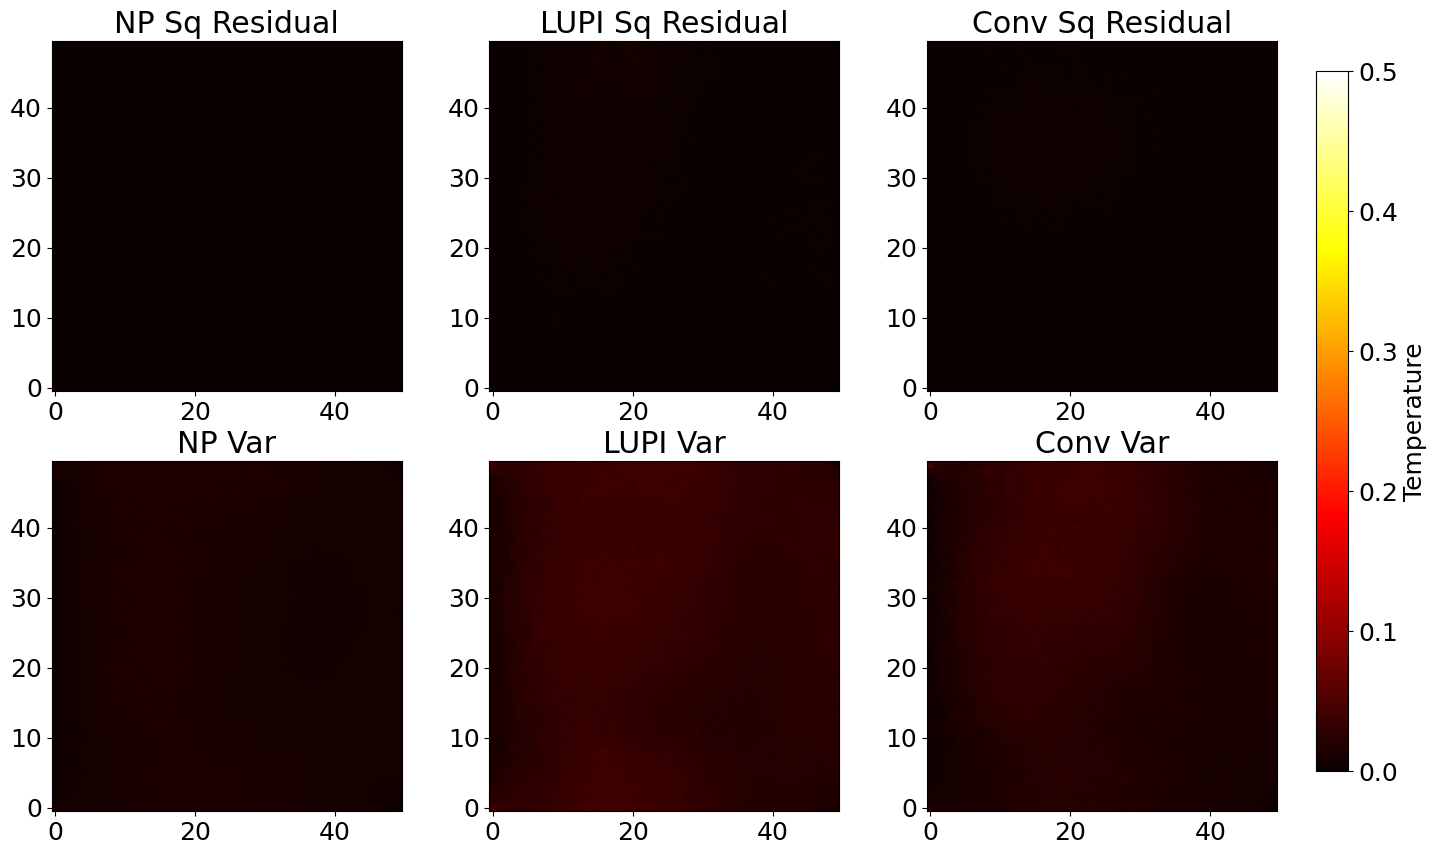

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'width_ratios': [1, 1, 1]})
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])

# Set up the subplots
titles = ['NP Sq Residual', 'LUPI Sq Residual', 'Conv Sq Residual', 'NP Var', 'LUPI Var', 'Conv Var']
data = [(y_mean - y_target)**2, (lupi_y_mean - y_target)**2, (conv_y_mean - y_target)**2, y_var, lupi_y_var, conv_y_var]
# data = [data1, data2, data3, data4]

images = []

# Plot initial heatmaps
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])
    image = ax.imshow(data[i][0], cmap='hot', interpolation='nearest', animated=True, vmin=0.0, vmax=0.5)
    images.append(image)

    # Invert the y-axis
    ax.invert_yaxis()

    # Modify the y-axis ticks and tick labels
    # ax.set_yticks(np.arange(y_target.shape[1]))  # Set the tick positions
    # ax.set_yticklabels(np.linspace(0, y_target.shape[1], 3)[::-1])  # Set the tick labels in reverse order


# Create the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of the colorbar
cbar = fig.colorbar(images[0], cax=cbar_ax)
cbar.set_label('Temperature')

# Update heatmaps for each time step
def update_heatmaps(frame):
    for i, image in enumerate(images):
        image.set_array(data[i][frame])

# Create the animation
ani = animation.FuncAnimation(fig, update_heatmaps, frames=y_target.shape[0], interval=25)

# Save the animation as GIF
ani.save('residuals_variance.gif', writer='pillow')

# Show the plot
plt.show()


## LUPI metrics

/Users/alexking/Documents/part_III_project/./neural-processes/visualise.py:276: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  entropy[np.isnan(entropy)] = 0


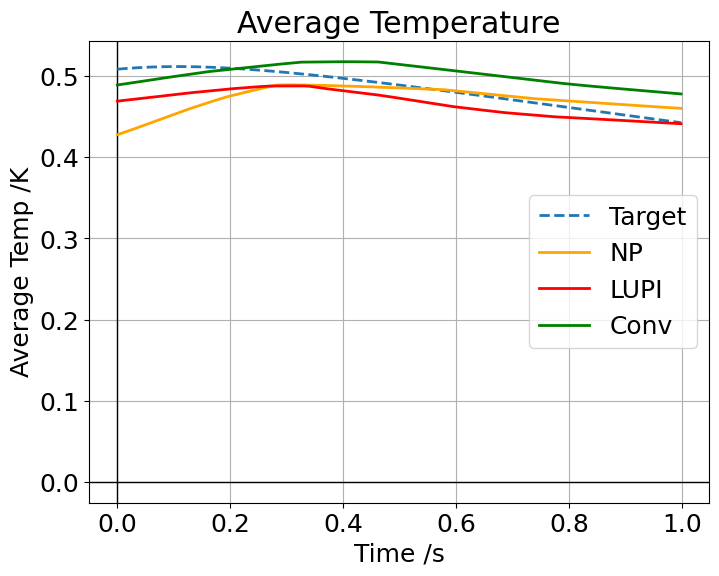

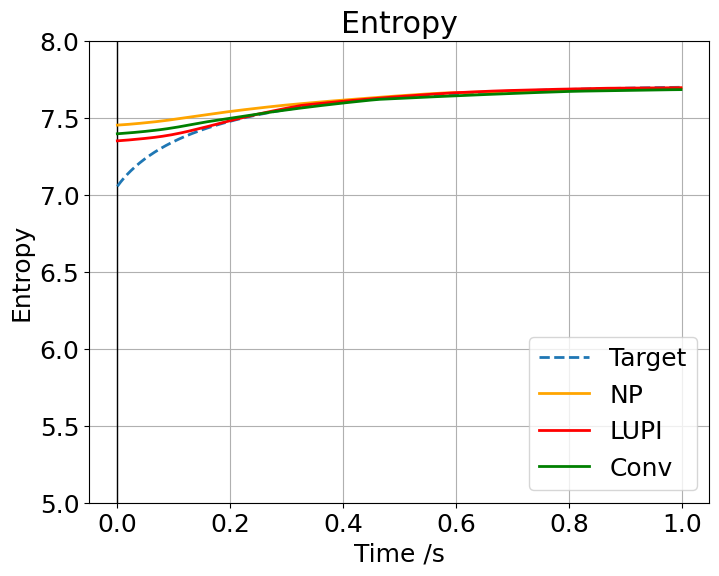

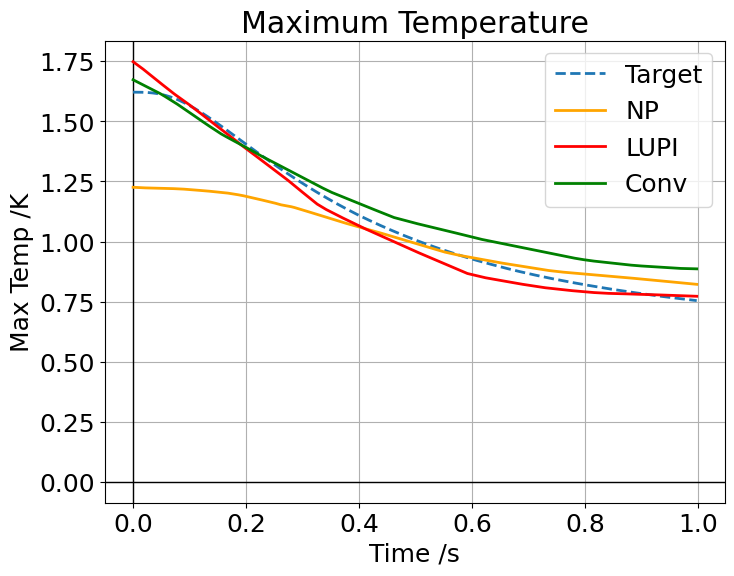

In [43]:
target_max_temp, target_energy, target_entropy = get_pi(y_target)
np_max_temp, np_energy, np_entropy = get_pi(y_mean)
lupi_max_temp, lupi_energy, lupi_entropy = get_pi(lupi_y_mean)
conv_max_temp, conv_energy, conv_entropy = get_pi(conv_y_mean)

plot_pi_data(target_energy, np_energy, lupi_energy, conv_energy, title='Average Temperature', xlabel='Time /s', ylabel='Average Temp /K')
plot_pi_data(target_entropy, np_entropy, lupi_entropy, conv_entropy, title='Entropy', xlabel='Time /s', ylabel='Entropy')
plot_pi_data(target_max_temp, np_max_temp, lupi_max_temp, conv_max_temp, title='Maximum Temperature', xlabel='Time /s', ylabel='Max Temp /K')



## Investigate Neumann BCs for Solver


Vary the grid size to see if the average temperature stays more constant

In [67]:
out_energys=[]

for v in [50, 100, 300]:
    dimensions_test = {
        't_dim' : 1,
        'y_dim' : v**2,
        'r_dim' : 128,
        'h_dim' : 128,
        'z_dim' : 128,
        'max_iter_time' : 500,
        'grid_size' : v,
        'num_samples' : 120,
        'num_context' : 0,
        'num_target' : 0,
        'batch_size' : 2,
        'num_channels' : 16,
        'pi_dim' : 4
    }

    assert dimensions_test['grid_size']**2 == dimensions_test['y_dim']
    assert dimensions_test['num_context'] + dimensions_test['num_target'] <= dimensions_test['max_iter_time']

    # parameters
    grid_size = v
    num_samples = dimensions_test['num_samples']
    square_range = (5, 15) # side length of initial hot square
    temp_range = (1.0, 2.0)
    # diffusion_coef = 0.25 * dimensions_test['max_iter_time'] # upper limit for stable FDM solver

    # assert diffusion_coef <= 0.25 * dimensions_test['max_iter_time']

    initial_conditions_test = Initial_Conditions(
        max_iter_time=dimensions['max_iter_time'], grid_size=grid_size
    )

    meta_data_test = Diffusion_Data(
        num_samples=num_samples,
        max_iter_time=dimensions_test['max_iter_time'],
        grid_size=grid_size,
        initial_conditions=initial_conditions_test,
        square_range=square_range,
        temp_range=temp_range,
        diffusion_coef=0.25 * dimensions_test['max_iter_time'],
        sigma=3
    )

    time_array_test = meta_data_test.time_array

    out_energy = torch.full((dimensions_test['max_iter_time'],), 0)

    for ds_num in range(dimensions_test['num_samples']-1):
        ds = MetaData(meta_data_test.data, ds_num=ds_num)
        pi = Pi(ds.pi)
        out_energy = out_energy + pi.energy

    out_energy = out_energy / dimensions_test['num_samples']
    out_energys.append(out_energy)


/Users/alexking/Documents/part_III_project/./neural-processes/heat_diffusion_dataset.py:184: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  entropy[np.isnan(entropy)] = 0


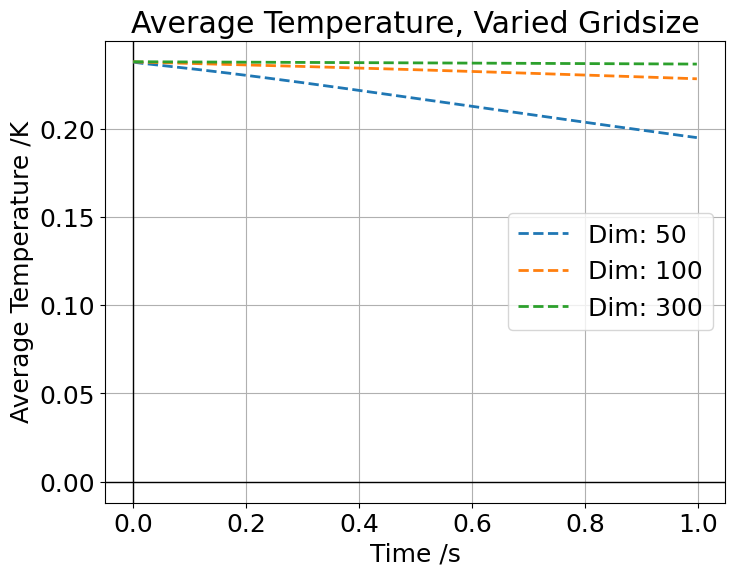

tensor(0.9944)


In [68]:
fig = plt.figure()
plt.axhline(color="black")
plt.axvline(color="black")
plt.xlabel('Time /s')
plt.ylabel('Average Temperature /K')
plt.title('Average Temperature, Varied Gridsize')
plt.plot([i / len(out_energys[0]) for i in range(len(out_energys[0]))], out_energys[0], label="Dim: {}".format(50), ls="--", linewidth=2)
plt.plot([i / len(out_energys[1]) for i in range(len(out_energys[1]))], out_energys[1], label="Dim: {}".format(100), ls="--", linewidth=2)
plt.plot([i / len(out_energys[2]) for i in range(len(out_energys[2]))], out_energys[2], label="Dim: {}".format(300), ls="--", linewidth=2)
plt.legend()
plt.grid()
plt.show()

print(out_energy[-1] / out_energy[0])